In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, TimeDistributed
from keras import optimizers

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
raw_data = np.loadtxt(open("EEG.csv", "rb"), delimiter=",", skiprows=0)
X_raw = raw_data[:,:-1]

In [3]:
# Data cleaning on X
upper_threshold = 4800
lower_threshold = 3800
too_big = X_raw>upper_threshold
too_small = X_raw<lower_threshold
X_cleaned = np.copy(X_raw)
X_cleaned[too_big] = upper_threshold
X_cleaned[too_small] = lower_threshold

In [4]:
X = (X_cleaned - np.mean(X_cleaned)) / np.std(X_cleaned)
y = raw_data[:,-1]

In [5]:
X.shape

(14980, 14)

In [6]:
num_train = 7000
num_val = 7000
X_train = X[:num_train,:]
y_train = y[:num_train]
X_val = X[num_train:num_train+num_val,:]
y_val = y[num_train:num_train+num_val]
X_test = X[num_train+num_val:,:]
y_test = y[num_train+num_val:]

In [7]:
batch_size = 70
train_batch_length = int(num_train/batch_size)
X_train_batch = np.zeros((batch_size,train_batch_length,X.shape[-1]))
y_train_batch = np.zeros((batch_size,train_batch_length))
for i in range(train_batch_length):
    X_train_batch[:,i,:] = X_train[i*batch_size:(i+1)*batch_size,:]
    y_train_batch[:,i] = y_train[i*batch_size:(i+1)*batch_size]

val_batch_length = int(num_val/batch_size)
X_val_batch = np.zeros((batch_size,val_batch_length,X.shape[-1]))
y_val_batch = np.zeros((batch_size,val_batch_length))
for i in range(val_batch_length):
    X_val_batch[:,i,:] = X_val[i*batch_size:(i+1)*batch_size,:]
    y_val_batch[:,i] = y_val[i*batch_size:(i+1)*batch_size]
y_train_batch = y_train_batch.reshape((y_train_batch.shape[0],y_train_batch.shape[1],1))
y_val_batch = y_val_batch.reshape((y_val_batch.shape[0],y_val_batch.shape[1],1))

In [8]:
print(X_train_batch.shape)
print(y_train_batch.shape)

(70, 100, 14)
(70, 100, 1)


In [9]:
model = Sequential()
model.add(GRU(256,return_sequences=True, stateful = True,activation = 'tanh',batch_input_shape=X_train_batch.shape))
model.add(Dropout(0.5))
model.add(GRU(128,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))
model.add(GRU(64,return_sequences=True, stateful = True,activation = 'tanh'))
model.add(Dropout(0.5))

model.add(TimeDistributed(Dense(1,activation = "sigmoid")))
adam = optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(optimizer = adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
history = model.fit(X_train_batch, y_train_batch,validation_data = (X_val_batch,y_val_batch), epochs=80, batch_size=batch_size)

Train on 70 samples, validate on 70 samples
Epoch 1/80
70/70 [==============================] - 6s - loss: 0.7013 - acc: 0.4913 - val_loss: 0.7024 - val_acc: 0.4424
Epoch 2/80
70/70 [==============================] - 3s - loss: 0.6898 - acc: 0.5386 - val_loss: 0.6708 - val_acc: 0.5677
Epoch 3/80
70/70 [==============================] - 3s - loss: 0.6926 - acc: 0.5313 - val_loss: 0.6898 - val_acc: 0.6231
Epoch 4/80
70/70 [==============================] - 3s - loss: 0.6737 - acc: 0.5956 - val_loss: 0.7149 - val_acc: 0.4460
Epoch 5/80
70/70 [==============================] - 2s - loss: 0.6728 - acc: 0.5433 - val_loss: 0.6835 - val_acc: 0.5310
Epoch 6/80
70/70 [==============================] - 2s - loss: 0.6551 - acc: 0.6313 - val_loss: 0.6577 - val_acc: 0.6000
Epoch 7/80
70/70 [==============================] - 2s - loss: 0.6477 - acc: 0.6511 - val_loss: 0.6604 - val_acc: 0.5829
Epoch 8/80
70/70 [==============================] - 2s - loss: 0.6371 - acc: 0.6847 - val_loss: 0.6816 - val_

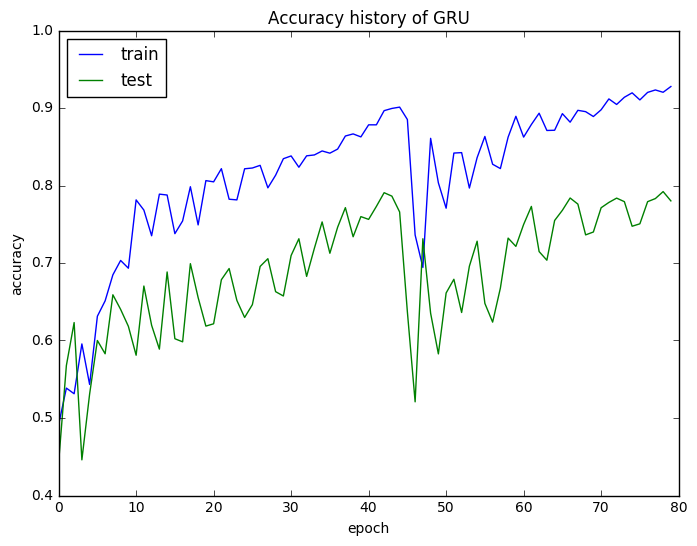

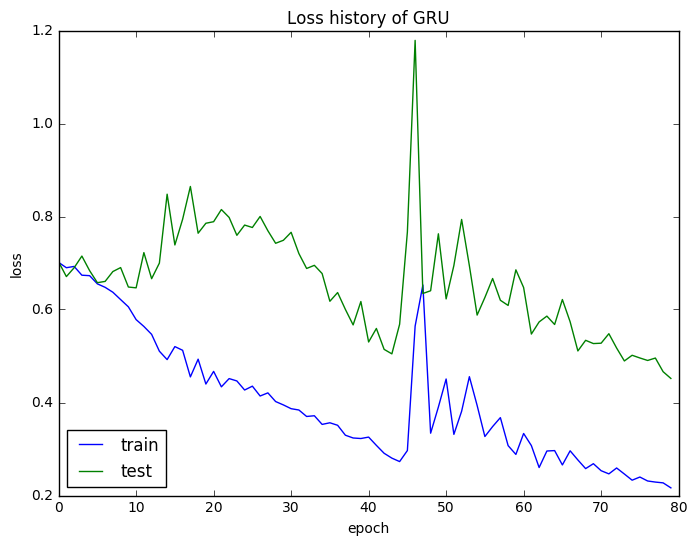

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy history of GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss history of GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()